In [1]:
# Plot the Hellinger distance for LWP at IQQ and surrounding areas:
# Following Schemann et al., 2020!

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
plt.rc('font', size=12) 
plt.style.use('seaborn-poster')

outputdir = "/home/qwertz/Dokumente/N_eigene_Dokumente/Geo_Met_MSc/Semester_4_5/Thesis_prep_Juni_23/MA/master_plots/08_hellinger/"

#######################################################################

file1 = "/home/qwertz/data_js_icon_22_23_August_2018/cloud_DOM01.20180822.selvar.int.nc"
file6 = "/home/qwertz/data_js_icon_22_23_August_2018/cloud_DOM01_ML_20180823.selvar.int.nc"
ds_icon22 = xr.open_dataset(file1, engine="netcdf4")
ds_icon23 = xr.open_dataset(file6, engine="netcdf4")
lwp_icon = xr.concat([ds_icon22["tqc"], ds_icon23["tqc"]], dim="time")
reduced_icon = lwp_icon.sel(time=slice(20180822.0,20180824.0))

file_iqq = "/home/qwertz/data_js_icon_22_23_August_2018/stat_IQQ_all-times.nc"
ds_iqq = xr.open_dataset(file_iqq)
lwp_iqq = ds_iqq["tqc"].isel(ncells=0)
reduced_iqq = lwp_iqq.sel(time=slice(20180822.0,20180824.0))

#######################################################################

def hellinger_distance(p_array, q_array):

    # Wandle Verteilungen in Wahrscheinlichkeitsverteilungen:
    #if np.nansum(p_array)==0:
    #    sump = 1.
    #else:
    sump = np.nansum(p_array)
    #if np.nansum(q_array)==0:
    #    sumq = 1.
    #else:
    sumq = np.nansum(q_array)

    # Berechne Hellinger-Distanzen:
    summe = 0.
    for i, (pi, qi) in enumerate(zip(p_array, q_array)):
        summe += ( np.sqrt(pi/sump) - np.sqrt(qi/sumq) )**2
    hellinger = np.sqrt(summe) / np.sqrt(2)
    return hellinger

#######################################################################
# Interpolate on smaller grid:
interp_func = interp1d(reduced_iqq['time'].values, reduced_iqq.values)
interpolated_iqq = interp_func(reduced_icon["time"].values)

#######################################################################

hellingers = np.zeros(len(lwp_icon["ncells"].values))
for cell in lwp_icon["ncells"].values:
    single_hell = hellinger_distance(interpolated_iqq, reduced_icon.isel(ncells=cell).values)
    hellingers[cell] = single_hell
#######################################################################




/home/qwertz/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/qwertz/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/tmp/ipykernel_21935/1681631360.py:44: RuntimeWarning: invalid value encountered in scalar divide
  summe += ( np.sqrt(pi/sump) - np.sqrt(qi/sumq) )**2


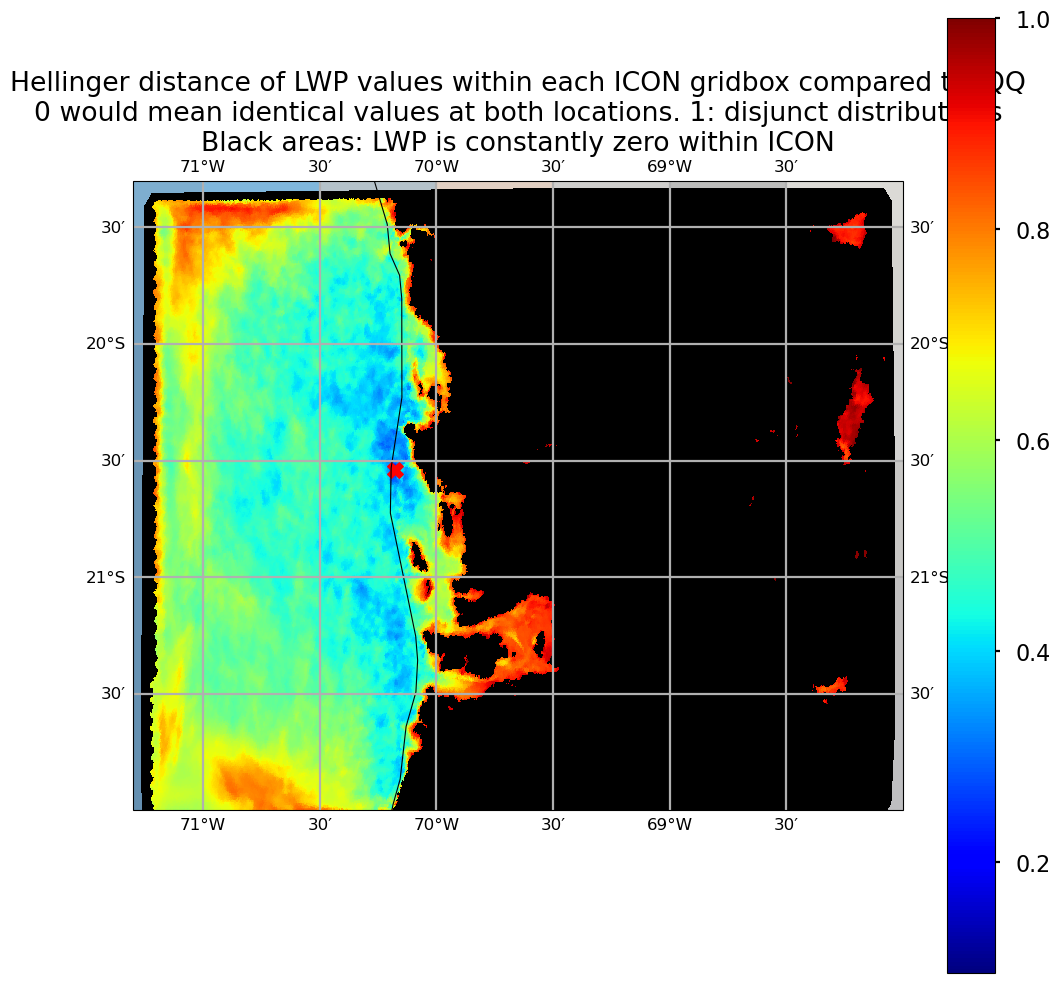

In [2]:
# Create same plot as Vera:

#####################################
import xarray as xr
import matplotlib.tri as tri
import numpy as np

import seaborn as sns
import matplotlib as mpl
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import psyplot.project as psy

# Cartopy is used independently from psyplot
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER,LATITUDE_FORMATTER

#####################################

gridfile = "/home/qwertz/data_js_icon_22_23_August_2018/chile_square_0628m.nc"
gridds = xr.open_dataset(gridfile, engine="netcdf4")

#####################################
# Convert vertex coordinates from radians to degrees
x      = np.rad2deg(gridds.clon)
y      = np.rad2deg(gridds.clat)
# Create  Delaunay triangulation. 
triang = tri.Triangulation(x, y)

################################
# var = lwp_icon.isel(time=0)
# var = [int(index) for index in indices]
var = hellingers
################################

cmap = mpl.colormaps["jet"]  # viridis + red war auch gut...
cmap.set_bad(color='black')

fig = plt.figure(figsize=(10,10))
pc = ccrs.PlateCarree()
ax = plt.axes(projection=pc)
ax.stock_img()
ax.coastlines('50m', linewidth=0.8)
ax.add_feature(cfeature.LAKES,
               edgecolor='black', facecolor='none',
               linewidth=0.8)
ax.set_extent([-71.3, -68, -22, -19.3], crs=ccrs.PlateCarree())
# plt.figure
tpc = ax.tripcolor(triang, var, transform=ccrs.PlateCarree(), cmap = cmap) # jet, rainbow
ax.scatter([-70.1772694], [-20.539444],color="red", marker="X", linewidth=1.)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
plt.title("Hellinger distance of LWP values within each ICON gridbox compared to IQQ\n\
0 would mean identical values at both locations. 1: disjunct distributions\n\
Black areas: LWP is constantly zero within ICON")
fig.colorbar(tpc, fraction=0.08)
plt.tight_layout()
plt.savefig(outputdir+"hellinger.png")
# or:
# plt.tricontourf(triang, var, transform=ccrs.PlateCarree() )

###############################################################
# Warum erreiche ich Werte größer als 1?XXX
# Antwort: Nutze keine Verteilung, sondern eine Wahrscheinlichkeitsdichtefunktion.XXX
# => Wie gehe ich mit Braunen Berecihen aufgrund von Summe 0 um?XXX

In [3]:
# Check Domain for UCLA:

import numpy as np

######################################

def degrees_lat2distance(delta_degrees):
    # Eingabe in degree erzeugt Ausgabe in m
    factor = 12730000*np.pi/180
    return delta_degrees * factor

print(degrees_lat2distance(22-19)/1000, "km")

######################################

def degree_lon2distance(delta_lon, lat=20.5):
    # Eingabe in degree erzeugt Ausgabe in m
    R = 12730000 * abs(np.cos(np.deg2rad(lat)))
    lon_factor =  R * np.pi / 180
    return lon_factor * delta_lon

print(degree_lon2distance(3.3, lat=20.5)/1000, "km")
print(np.sqrt(252448))
print(600000/500)

666.5412413366344 km
686.7637081218429 km
502.4420364579381
1200.0
